In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import genjax
from genjax import ChoiceMapBuilder as C
from genjax import gen, bernoulli, normal, uniform
from genjax import truncated_normal as truncnorm

import sys
sys.path.append("../src/")
from maskcombinator_model import *

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils import scatter_animation
from IPython.display import HTML


genjax.pretty()

In [3]:
class JaxKeyHandler():
    def __init__(self, seed):
        self.seed = seed
        self.key = jax.random.PRNGKey(seed)

    def __call__(self, n_keys=1):
        if n_keys == 1:
            _, subkey = jax.random.split(self.key)
            self.key = subkey
            return self.key
        else:
            keys = jax.random.split(self.key, n_keys)
            self.key = keys[-1]
            return keys
        
seed = 124
keygen = JaxKeyHandler(seed)

In [5]:
key = keygen()
max_fireflies = jnp.arange(1, 5)
time_steps = jnp.arange(40) < 40
gt_tr = jax.jit(multifirefly_model.simulate)(key, (max_fireflies, time_steps))


gt_chm = gt_tr.get_choices()
observed_xs, observed_ys = get_observations(gt_chm)
gt_xs, gt_ys = get_gt_locations(gt_chm)

anim = scatter_animation(observed_xs, observed_ys)
plt.title("Observations only")
display(HTML(anim.to_jshtml()))
plt.close()


anim = scatter_animation(observed_xs, observed_ys, gt_xs, gt_ys)
display(HTML(anim.to_jshtml()))
plt.close()

Generative model functions:

assess -- log probability of an observation under a trace (requires complete choicemap)

importance -- same as assess but without full choicemap (importance sample with proposal to get full choicemap, 
                                                          get model logprobs using assess)
                                                          
update -- convenience to save computation when trace isn't changing

What I want are the following:

1. initialization proposal, initialization prior
2. dynamics proposal, dynamics prior
3. observation / likelihood function

Then, at each step (after initialization), I want to:

1. compute $Q(x_t; x_{t-1}, y_t)$ by calling `.importance` on the dynamics proposal
2. compute $P(x_t | x_{t-1})$ by using the choices from our proposal and calling `.assess` on the prior (model dynamics)
3. compute $P(y_t | x_t)$ using observation model
4. Calculate weights as: $\frac{P(y_t | x_t) P(x_t | x_{t-1})}{Q(x_t; x_{t-1}, {y_t})}$
5. Resample particles by drawing from `Categorical(weights)` M times


Let's try to take apart our existing model and re-factor it to make it easier to use those components

### 1. Initialization

Our initialization model will sample N and initalize fireflies using a mask over the max

Our proposal can take the first observation, and initalize in the vicinity of any observed blinks

In [89]:
MAX_VELOCITY = 3.
MIN_VELOCITY = -3.
SCENE_SIZE = 32.

In [90]:
@gen
def init_firefly_at_random():
    init_x = uniform(1., SCENE_SIZE) @ "x"
    init_y = uniform(1., SCENE_SIZE) @ "y"

    vx = truncnorm(0., .5, MIN_VELOCITY, MAX_VELOCITY) @ "vx"
    vy = truncnorm(0., .5, MIN_VELOCITY, MAX_VELOCITY) @ "vy"

    blink_rate = normal(0.1, 0.01) @ "blink_rate"
    blinking = 0
    #state_duration = jax.lax.select(True, 0, 0)

    firefly = {
        "x": init_x,
        "y": init_y,
        "vx": vx,
        "vy": vy,
        "blink_rate": blink_rate,
        "blinking": blinking,
    }

    return firefly

@gen
def init_firefly_at_loc(obs_x, obs_y):
    """
    Takes in observed locations and initializes 
    fireflies if the locations are in bounds
    """
    vx = truncnorm(0., .5, MIN_VELOCITY, MAX_VELOCITY) @ "vx"
    vy = truncnorm(0., .5, MIN_VELOCITY, MAX_VELOCITY) @ "vy"

    # If obs_x / obs_y are < 0, sample starting position uniformly
    is_valid_x = obs_x > 0.
    is_valid_y = obs_y > 0.
    x = truncnorm.or_else(uniform)(is_valid_x, (obs_x - vx, 0.01, 0., SCENE_SIZE), (0., SCENE_SIZE)) @ "x"
    y = truncnorm.or_else(uniform)(is_valid_y, (obs_y - vy, 0.01, 0., SCENE_SIZE), (0., SCENE_SIZE)) @ "y"

    blink_rate = normal(0.1, 0.01) @ "blink_rate"
    blinking = 0
    
    firefly = {
        "x": x,
        "y": y,
        "vx": vx,
        "vy": vy,
        "blink_rate": blink_rate,
        "blinking": blinking,
    }

    return firefly

@gen 
def model_init_fireflies(max_fireflies):
    n_fireflies = labcat(unicat(max_fireflies), max_fireflies) @ "n_fireflies"
    masks = jnp.array(max_fireflies <= n_fireflies)
    init_states = init_firefly_at_random.mask().vmap(in_axes=(0))(masks) @ "init"
    return init_states


@gen 
def proposal_init_fireflies(max_fireflies, x_obs, y_obs):
    """
    max_fireflies: jnp.array of the form [1, 2, 3, ..., max_fireflies]
    x_obs, y_obs: (max_fireflies,) array with observations. Valid observations 
          are anything inside the scene limits
    """
    num_valid_obs = jnp.sum(jnp.where(x_obs > -1, 1, 0))
    firefly_probs = jnp.where(max_fireflies < num_valid_obs + 1, 0.01, 1.) 
    firefly_probs = firefly_probs / jnp.sum(firefly_probs)
    n_fireflies = labcat(unicat(firefly_probs), max_fireflies) @ "n_fireflies"
    masks = jnp.array(max_fireflies <= n_fireflies)
    init_states = init_firefly_at_loc.mask().vmap(in_axes=(0, 0, 0))(masks, x_obs, y_obs) @ "init"
    return init_states


test = False
if test:
    max_fireflies = jnp.arange(1, 5)
    x_obs = jnp.array([12., -10., -10., -10.])
    y_obs = jnp.array([12., -10., -10., -10.])

    trace = proposal_init_fireflies.simulate(keygen(), (max_fireflies, x_obs, y_obs))
    x = trace.get_choices()["init", :, "x"]
    print(x.value[x.flag], " original: ", x_obs)

In [150]:
@gen 
def model_dynamics_step(prev_state):
    """
    Single step dynamics for an individual prev_state.
    Random walk with small drift on velocity and position
    truncated to min/max velocity and position in scene bounds

    Args:
        prev_state: dictionary of prev_state 
    Returns: 
        prev_state: dictionary of updated state
    """
    prev_x = prev_state["x"]
    prev_y = prev_state["y"]
    prev_vx = prev_state["vx"]
    prev_vy = prev_state["vy"]
    blink_rate = prev_state["blink_rate"]

    # Sample a new trajectory
    new_vx = genjax.truncated_normal(prev_vx, .3, MIN_VELOCITY, MAX_VELOCITY) @ "vx"
    new_vy = genjax.truncated_normal(prev_vy, .3, MIN_VELOCITY, MAX_VELOCITY) @ "vy"

    # Switch direction on collision
    new_vx = jnp.where((prev_x + new_vx >= SCENE_SIZE - 1.) | (prev_x + new_vx <= 1.), -new_vx, new_vx)
    new_vy = jnp.where((prev_y + new_vy >= SCENE_SIZE - 1.) | (prev_y + new_vy <= 1.), -new_vy, new_vy)

    # Clip new position inside scene
    new_x = jnp.clip(prev_x + new_vx, 0., SCENE_SIZE)
    new_y = jnp.clip(prev_y + new_vy, 0., SCENE_SIZE)

    # Add some noise
    new_x = truncnorm(new_x, 0.01, 0., SCENE_SIZE) @ "x" 
    new_y = truncnorm(new_y, 0.01, 0., SCENE_SIZE) @ "y"
    
    # Update blinking 
    blinking = genjax.bernoulli(blink_rate) @ "blinking"

    new_state = {
        "x": new_x,
        "y": new_y,
        "vx": new_vx,
        "vy": new_vy,
        "blink_rate": blink_rate,
        "blinking": blinking,
    }
    
    return new_state

def calculate_distances_from_pos(position, observations):
    """
    Args:
        position: (2,) array of (x, y) position
        observations: (2, n_objects) matrix of (x, y) observations
                        where invalid observations are < 0.
    Returns:
        distances: (n_objects, n_objects) matrix with L2 distances for each object, observation pair
                    where distances to invalid observations is -jnp.inf
    """    
    # Expand dims for broadcasting and compute norm
    pos_expanded = jnp.expand_dims(position, 1)  # (2, 1)
    diff = pos_expanded - observations
    distances = jnp.linalg.norm(diff, axis=0)
    valid = jnp.all(observations > 0., axis=0)
    return jnp.where(valid , distances, jnp.inf)

@gen
def proposal_dynamics_step(prev_state, obs_x, obs_y):
    prev_x = prev_state["x"]
    prev_y = prev_state["y"]
    prev_vx = prev_state["vx"]
    prev_vy = prev_state["vy"]
    blink_rate = prev_state["blink_rate"]
    blinking = prev_state["blinking"]

    observed_positions = jnp.stack([obs_x, obs_y], axis=0)
    distances = calculate_distances_from_pos(jnp.stack([prev_x, prev_y]), observed_positions)
    nearby_blinks = jnp.any(distances < (MAX_VELOCITY * jnp.sqrt(2)))
    blinking = bernoulli.or_else(bernoulli)(nearby_blinks, (0.99,), (0.000,)) @ "blinking"
    
    index = jax.lax.cond(nearby_blinks, lambda: jnp.argmin(distances), lambda: -1) # index of closest blink
                 
    vx = truncnorm.or_else(truncnorm)(nearby_blinks, (obs_x[index] - prev_x, 0.01, MIN_VELOCITY, MAX_VELOCITY), 
                                                    (prev_vx, 0.3, MIN_VELOCITY, MAX_VELOCITY)) @ "vx"
    vy = truncnorm.or_else(truncnorm)(nearby_blinks, (obs_y[index] - prev_y, 0.01, MIN_VELOCITY, MAX_VELOCITY), 
                                      (prev_vy, 0.3, MIN_VELOCITY, MAX_VELOCITY)) @ "vy"
    
    # Switch direction on collision
    vx = jnp.where((prev_x + vx >= SCENE_SIZE - 1.) | (prev_x + vy <= 1.), -vx, vx)
    vy = jnp.where((prev_y + vy >= SCENE_SIZE - 1.) | (prev_y + vy <= 1.), -vy, vy)

    x = truncnorm(prev_x + vx, 0.01, 0., SCENE_SIZE) @ "x"
    y = truncnorm(prev_y + vy, 0.01, 0., SCENE_SIZE) @ "y"
    
    new_state = {
        "x": x,
        "y": y,
        "vx": vx,
        "vy": vy,
        "blinking": blinking,
        "blink_rate": blink_rate
    }
    return new_state

@gen
def masked_proposal_dynamics(states, obs_x, obs_y):
    """
    States is a masked object with a dict of state values inside
    masks is an (n_fireflies,) array of mask vals
    obs_x and obs_y are (n_fireflies,) vectors of observations
    """
    masks = states.flag
    proposal_fn = proposal_dynamics_step.mask().vmap(in_axes=(0, 0, None, None))
    new_states = proposal_fn(masks, states.value, obs_x, obs_y) @ "steps"
    return new_states

@gen
def masked_model_dynamics(states):
    """
    States is an (n_fireflies,) array of dicts
    masks is an (n_fireflies,) array of mask vals
    obs_x and obs_y are (n_fireflies,) vectors of observations
    """
    masks = states.flag
    model_fn = model_dynamics_step.mask().vmap(in_axes=(0, 0))
    new_states = model_fn(masks, states.value) @ "steps"
    return new_states

In [151]:
test_distance_calc = True
if test_distance_calc:
    obs_x = jnp.array([10., 14., -10., -10.])
    obs_y = jnp.array([10., 14., -10., -10.])
    observations = jnp.stack([obs_x, obs_y], axis=0)
    pos = jnp.stack([10., 10.])

    distance = calculate_distances_from_pos(pos, observations)
    allclose = jnp.allclose(distance, jnp.array([0., 7.071068, jnp.inf, jnp.inf]))
    print(allclose)
    print(distance)
    print(distance < (MAX_VELOCITY * jnp.sqrt(2)))

False
[0.       5.656854      inf      inf]
[ True False False False]


In [152]:
def test_sample_from_dynamics_proposal():
    max_fireflies = jnp.arange(1, 5)
    x_obs = jnp.array([10., -10., -10., -10.])
    y_obs = jnp.array([10., -10., -10., -10.])
    choices, score, init_states = proposal_init_fireflies.propose(keygen(), (max_fireflies, x_obs, y_obs))
    proposal_choices, proposal_score, proposal_states = masked_proposal_dynamics.propose(keygen(), (init_states, x_obs, y_obs))

    return init_states, proposal_choices, proposal_score, proposal_states

def prop_chm_to_model_chm(prop_chm):
    model_chm = C.n()
    model_chm = C["steps", "blinking"].set(prop_chm["steps", "blinking"])
    model_chm = C["steps", "x"].set(prop_chm["steps", "x"]) | model_chm
    model_chm = C["steps", "y"].set(prop_chm["steps", "y"]) | model_chm
    model_chm = C["steps", "vx"].set(prop_chm["steps", "vx"]) | model_chm
    model_chm = C["steps", "vy"].set(prop_chm["steps", "vy"]) | model_chm
    
    return model_chm

In [153]:
if False:
    init_states, proposal_choices, proposal_w, proposal_states = test_sample_from_dynamics_proposal()
    proposal_constraints = prop_chm_to_model_chm(proposal_choices)
    prior_score, prior_retval = masked_model_dynamics.assess(proposal_constraints, (init_states,))
    print(prior_score.mean())

In [154]:
# Test the dynamics proposal
test_dynamics_proposal = False
if test_dynamics_proposal:
    firefly_state = {"x": jnp.float32(19.), "y": jnp.float32(12.), "vx": jnp.float32(1.), "vy": jnp.float32(1.), "blinking": 0, "blink_rate": jnp.float32(0.01)}
    observed_xs = jnp.array([16., -10., -10., -10.]).astype(jnp.float32)
    observed_ys = jnp.array([10.2, -10., -10., -10]).astype(jnp.float32)
    key = keygen()
    trace, weight, retval = masked_proposal_dynamics.propose(key, ((firefly_state, observed_xs, observed_ys),))
    print(trace["blinking"])
    print(weight)

In [155]:
@gen 
def observation_likelihood(xs, ys, blinks):
    observed_xs = jnp.full_like(xs, -10.)
    observed_ys = jnp.full_like(ys, -10.)
    
    # Use where to conditionally select values
    observed_xs = jnp.where(blinks, xs, observed_xs)
    observed_ys = jnp.where(blinks, ys, observed_ys)
    
    observed_xs = genjax.normal(observed_xs, 0.1) @ "observed_xs"
    observed_ys = genjax.normal(observed_ys, 0.1) @ "observed_ys"
    return jnp.stack([observed_xs, observed_ys])

# SMC loop

Now that we have our proposals and priors, we can write an SMC loop! First, we'll generate and visualize a sample trace.

Next, we write a loop as follows:
1. At timestep 1, take the first observation and generate a choicemap of constraints for the init proposal. Score under the prior 

In [156]:
def maybe_resample(key, log_weights_raw, ess_threshold):
    key, subkey = jax.random.split(key, 2)
    log_weights = log_weights_raw
    resample_inds = genjax.categorical.repeat(n=len(log_weights))
    resampled_inds = resample_inds(log_weights).simulate(subkey, ()).get_retval()
    log_total_weight = jax.nn.logsumexp(log_weights)
    log_normalized_weights = log_weights - log_total_weight
    log_ess = - jax.nn.logsumexp(2 * log_normalized_weights)
    ess = jnp.exp(log_ess)
    do_resample = ess < ess_threshold
    particle_inds = (do_resample * resampled_inds) + ((ess >= ess_threshold) * jnp.arange(len(log_weights)))
    return particle_inds, log_total_weight, log_normalized_weights, do_resample, ess

In [157]:
def prop_chm_to_model_chm(prop_chm):
    model_chm = C.n()
    model_chm = C["steps", "blinking"].set(prop_chm["steps", "blinking"])
    model_chm = C["steps", "x"].set(prop_chm["steps", "x"]) | model_chm
    model_chm = C["steps", "y"].set(prop_chm["steps", "y"]) | model_chm
    model_chm = C["steps", "vx"].set(prop_chm["steps", "vx"]) | model_chm
    model_chm = C["steps", "vy"].set(prop_chm["steps", "vy"]) | model_chm
    
    return model_chm

def construct_obs_chm(observed_xs, observed_ys):
    obs_chm = C["observed_xs"].set(observed_xs)
    obs_chm = C["observed_ys"].set(observed_ys) | obs_chm
    return obs_chm

def get_obs_input(model_chm):
    xs = get_masked_values(model_chm["steps", "x"])
    ys = get_masked_values(model_chm["steps", "y"])
    blinks = model_chm["steps", "blinking"].value
    return xs, ys, blinks


def get_obs_input_from_states(states):
    xs = jnp.where(states.flag, states.value["x"], -10.)
    ys = jnp.where(states.flag, states.value["y"], -10.)
    blinks = states.value["blinking"]
    return xs, ys, blinks

In [172]:
def run_particle_filter(gt_trace, gen_fns, n_particles, keygen, ess_threshold=50):
    init_prior, init_proposal, dynamics_prior, dynamics_proposal, likelihood = gen_fns
    ax_fireflies, run_steps = gt_trace.get_args()
    gt_chm = gt_trace.get_choices()
    all_x_obs, all_y_obs = get_observations(gt_chm)
    states_over_time = []
    weights_over_time = []
    resamples_over_time = []
    likelihood_over_time = []
    ess_over_time = []
    model_scores_over_time = []
    proposal_scores_over_time = []

    obs_x0 = all_x_obs[0]
    obs_y0 = all_y_obs[0]

    keys = keygen(n_particles)
    model_init_traces, model_scores = init_prior(keys, C.n(), (max_fireflies,)) 
    model_init_chms, model_states = jax.vmap(lambda tr: (tr.get_choices(), tr.get_retval()))(model_init_traces)

    keys = keygen(n_particles)
    prop_chms, prop_scores, prop_states = init_proposal(keys, (max_fireflies, obs_x0, obs_y0))
    
    # TODO: Render first state and score
    current_state = prop_states

    for step in tqdm(range(len(run_steps))):
        states_over_time.append(current_state)
        prev_state = current_state
        obs_x = all_x_obs[step] 
        obs_y = all_y_obs[step] 

        obs_x_broadcast = jnp.tile(obs_x, (n_particles, 1))
        obs_y_broadcast = jnp.tile(obs_y, (n_particles, 1))
        
        # Propose Q(x_t | x_t-1, y_t)
        proposed_constraints, prop_scores, prop_states = dynamics_proposal(keygen(n_particles), (prev_state, obs_x_broadcast, obs_y_broadcast))
        
        # Assess proposed values under prior ( P(x_t | x_{t-1}) )
        translated_prop_chms = jax.vmap(lambda ch: prop_chm_to_model_chm(ch))(proposed_constraints)
        model_scores, model_states = dynamics_prior(translated_prop_chms, (prev_state,))

        # Compute likelihood ( P(y_t | x_t) )        
        obs_chm = construct_obs_chm(obs_x, obs_y)
        obs_input = jax.vmap(lambda t: get_obs_input_from_states(t))(model_states)
        likelihood_traces, likelihood_scores = likelihood(keygen(n_particles), obs_chm, (obs_input))

        # Compute weights and possibly resample
        importance = model_scores - prop_scores
        weights = importance + likelihood_scores
        particle_indices, log_total_weight, normalized_weights, resampled, ess = maybe_resample(keygen(), weights, ess_threshold)
        current_state = model_states[particle_indices]
        
        # Track states
        likelihood_over_time.append(likelihood_scores)
        model_scores_over_time.append(model_scores)
        proposal_scores_over_time.append(prop_scores)

        resamples_over_time.append(resampled)
        ess_over_time.append(ess)
        weights_over_time.append(normalized_weights)


    metrics = {
        "prior_weights": model_scores_over_time,
        "proposal_weights": proposal_scores_over_time,
        "likelihoods": likelihood_over_time,
        "ess": ess_over_time,
        "resamples": resamples_over_time,
        "weights": weights_over_time,
    }
    return states_over_time, metrics

In [173]:
proposal_init = jax.jit(jax.vmap(proposal_init_fireflies.propose, in_axes=(0, None))) # Already operates over K fireflies
model_init = jax.jit(jax.vmap(model_init_fireflies.importance, in_axes=(0, None, None)))
dynamics_proposal = jax.jit(jax.vmap(masked_proposal_dynamics.propose, in_axes=(0, 0))) # maps over particles
dynamics_prior = jax.jit(jax.vmap(masked_model_dynamics.assess, in_axes=(0, 0)))
likelihood_jitted = jax.jit(jax.vmap(observation_likelihood.importance, in_axes=(0, None, 0)))

gen_fns = (model_init, proposal_init, dynamics_prior, dynamics_proposal, likelihood_jitted)

n_particles = 1000
ess_threshold = n_particles / 4
states_over_time, metrics = run_particle_filter(gt_tr, gen_fns, n_particles, keygen, ess_threshold)

  0%|          | 0/40 [00:00<?, ?it/s]

In [174]:
def print_vals_at_index(state, constraints, index):
    vals = ["x", "y", "vx", "vy", "blinking"]
    flags = state.flag[index]
    print(f"flags = {flags}")
    print()
    
    # Calculate max length of variable names for alignment
    max_val_len = max(len(val) for val in vals)
    
    for val in vals:
        # Get the value and constraint
        value = state.value[val][index]
        const = constraints["steps", index, val].value
        
        # Format floats to 2 decimal places if needed
        if isinstance(value, float):
            value = f"{value:.2f}"
        if isinstance(const, float):
            const = f"{const:.2f}"
            
        # Print aligned values using consistent spacing
        print(f"{'Input ' + val:<{max_val_len}} = {value}")
        print(f"{'constraint':<{max_val_len}} = {const}")
        print()
        
# print_vals_at_index(model_input_states[0], model_input_constraints[0], 6)

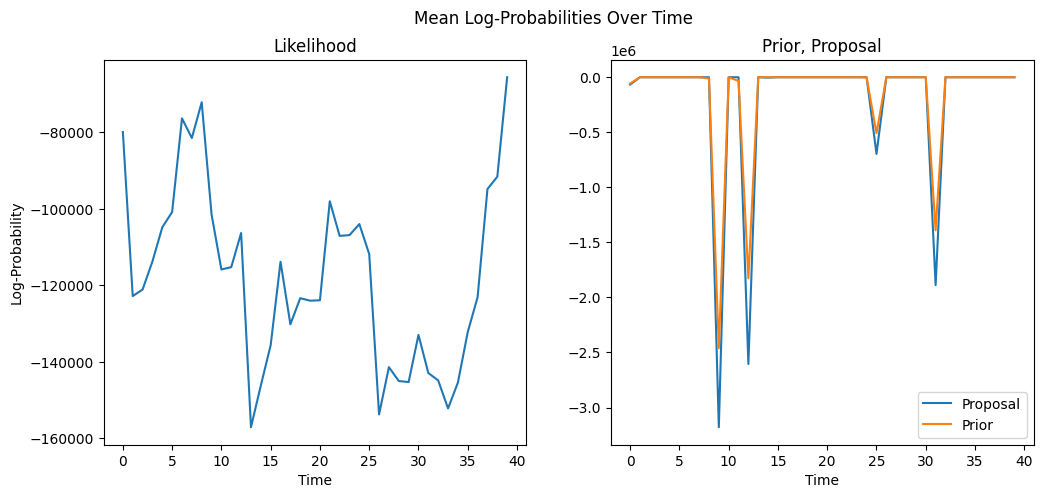

In [175]:
likelihoods = jnp.array(metrics["likelihoods"])  # Shape (40, 200)
likelihood_means = likelihoods.mean(axis=1)
likelihood_vars = likelihoods.var(axis=1)

proposal_scores = jnp.array(metrics["proposal_weights"])
prior_scores = jnp.array(metrics["prior_weights"])

# plt.subplots(111) is incorrect syntax - it should be (1, 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=False)

# Use ax instead of ax[0] since it's a single subplot
# for i in range(len(likelihoods)):
#     ax.scatter(jnp.ones(200) * i, likelihoods[i])
#     ax.set_yscale('log')

ax[0].plot(likelihood_means, label="Likelihood")
ax[0].set_title("Likelihood")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Log-Probability")
ax[1].set_title("Prior, Proposal")
ax[1].plot(proposal_scores.mean(axis=1), label="Proposal")
ax[1].plot(prior_scores.mean(axis=1), label="Prior")
plt.legend()
plt.xlabel("Time")
plt.suptitle("Mean Log-Probabilities Over Time")
plt.show()

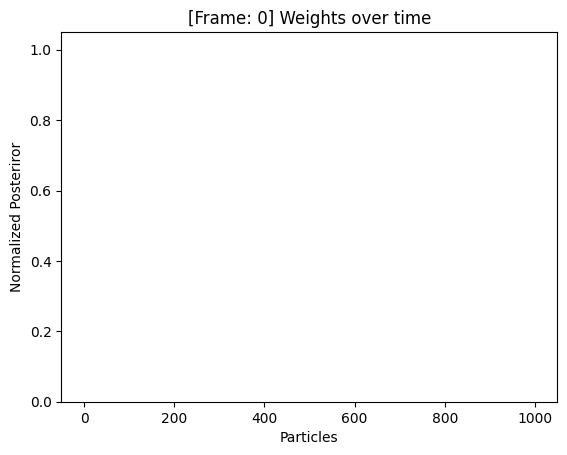

In [176]:
from matplotlib import animation

weights_over_time = metrics["weights"]

fig, ax = plt.subplots(1, 1)
bar = ax.bar(range(n_particles), jnp.exp(weights_over_time[0]))
plt.title("Weights over time")

def update(frame):
    weights = jnp.exp(weights_over_time[frame])
    for i, b in enumerate(bar):
        b.set_height(weights[i])

    ax.set_title(f"[Frame: {frame}] Weights over time")

plt.xlabel("Particles")
plt.ylabel("Normalized Posteriror")
anim=animation.FuncAnimation(fig, update, repeat=False, blit=False, frames=40,
                             interval=120)
HTML(anim.to_jshtml())


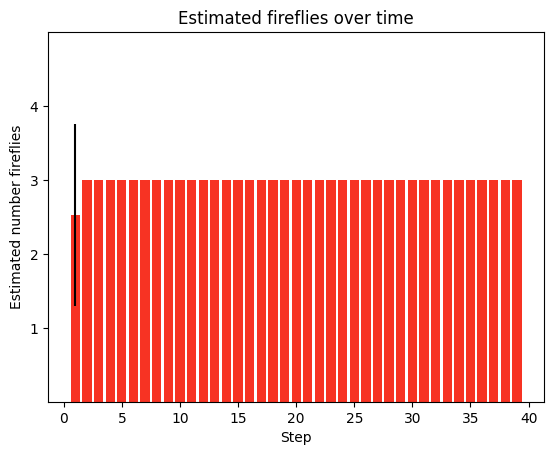

In [178]:
run_steps = len(observed_xs)
mean_n_fireflies = []
fig, ax = plt.subplots()
for i in range(run_steps - 1):
    states = states_over_time[i]
    n_fireflies = states.flag
    firefly_estimate = jnp.mean(jnp.sum(n_fireflies, axis=1))
    variance = jnp.var(jnp.sum(n_fireflies, axis=1))

    ax.errorbar(i + 1, firefly_estimate, variance, c="k")
    ax.bar(i + 1, firefly_estimate, color="#F73323")

plt.ylim(0, 5)
plt.yticks(range(1, 5), range(1, 5))
plt.plot(mean_n_fireflies)
plt.xlabel("Step")
plt.ylabel("Estimated number fireflies")
plt.title("Estimated fireflies over time")
plt.show()

In [179]:
def create_smc_animations(gt_chm, states_over_time, savedir="animations/"):
    gt_xs, gt_ys = get_gt_locations(gt_chm)
    observed_xs, observed_ys = get_observations(gt_chm)
    gt_n_fireflies = gt_chm["n_fireflies"]

    fig, axs = plt.subplots(1, 5, figsize=(30, 8))

    for i, ax in enumerate(axs):
        if i > 0:
            ax.set_title(f"{i}-Firefly Particles")

        ax.set_facecolor("black")
        ax.set_xlim(0, 32)
        ax.set_ylim(32, 0)

    firefly_colors = ["red", "green", "blue"]
    for t in tqdm(range(len(states_over_time))):
        states = states_over_time[t]

        for i, ax in enumerate(axs):
            ax.cla()
            ax.set_xlim(0, 32)
            ax.set_ylim(32, 0)

            if i > 0:
                ax.set_title(f"{i}-Firefly Particles")
            else:
                ax.set_title(f"Ground Truth")

        obs_x = observed_xs[t]
        obs_y = observed_ys[t]
        gt_x = gt_xs[t]
        gt_y = gt_ys[t]
        for i in range(gt_n_fireflies):
            if obs_x[i] > 0:
                axs[0].scatter(obs_x, obs_y, color="y", s=200)
            else:
                axs[0].scatter(gt_x, gt_y, color="r", alpha=0.6, facecolors='none', linestyle="--", s=200)

        axs[0].set_title("Ground Truth")

        # Prepare dictionaries for blinking and non-blinking data grouped by firefly count
        blinking_data = {i: ([], []) for i in range(1, 5)}  # x, y per firefly count
        non_blinking_data = {i: ([], []) for i in range(1, 5)}

        # Collect data for each state
        for i in range(n_particles):
            s = states[i]
            flags = s.flag
            n_fireflies = int(np.sum(flags))
            
            x, y = s.value["x"][flags], s.value["y"][flags]
            blinking = s.value["blinking"][flags]

            # Append blinking and non-blinking data
            blinking_data[n_fireflies][0].extend(x[blinking])
            blinking_data[n_fireflies][1].extend(y[blinking])

            non_blinking_data[n_fireflies][0].extend(x[~blinking])
            non_blinking_data[n_fireflies][1].extend(y[~blinking])

        # Plot collected data on corresponding axes
        for n_fireflies in range(1, 5):
            if non_blinking_data[n_fireflies][0]:  # Plot non-blinking fireflies
                axs[n_fireflies].scatter(
                    non_blinking_data[n_fireflies][0],
                    non_blinking_data[n_fireflies][1],
                    color="r",
                    linestyle="--",
                    facecolors='none',
                    s=100,
                    alpha=0.2,
                    label="Non-Blinking",
                )

            if blinking_data[n_fireflies][0]:  # Plot blinking fireflies
                axs[n_fireflies].scatter(
                    blinking_data[n_fireflies][0],
                    blinking_data[n_fireflies][1],
                    color="y",
                    marker="o",
                    s=100,
                    label="Blinking",
                )

        plt.suptitle(f"Inference Prediction [t={t}]")
        plt.tight_layout()
        plt.savefig(f"{savedir}/pf_frame_{t}.png")

In [ ]:
import subprocess
gt_chm = gt_tr.get_choices()
create_smc_animations(gt_chm, states_over_time)
subprocess.run([
    'ffmpeg',
    '-framerate', '10',
    '-y',
    '-i', 'animations/pf_frame_%d.png',
    '-pix_fmt', 'yuv420p',
    'animations/smc_animation.mp4'
], check=True)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# ffmpeg -framerate 10 -y -i "pf_frame_%d.png" -pix_fmt yuv420p  smc_animation.mp4